In [ ]:
!python3 --version

Python 3.7.12


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Imports

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2 as cv2
from tqdm import tqdm
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.utils import Sequence
import imageio

## Dataset Paths

In [ ]:
# Project Directory
PROJECT_DIR = "/content/drive/MyDrive/Mini_Project_II"

In [ ]:
import sys

sys.path.append(os.path.join(PROJECT_DIR,'notebooks'))

In [ ]:
from helpers import preprocess

## Dataset Validation

In [ ]:
train_datagen = preprocess.get_train_datagen(only_one_video=False,small_sample=True)

Removing Missing Data from csv
tt0493405.00 not found. Removing entry from data
tt0493405.01 not found. Removing entry from data
tt0493405.02 not found. Removing entry from data
kCppUtS9vLk.00 not found. Removing entry from data
kCppUtS9vLk.01 not found. Removing entry from data
EbcfiIeH63M.00 not found. Removing entry from data
EbcfiIeH63M.01 not found. Removing entry from data
EbcfiIeH63M.02 not found. Removing entry from data
pxxPznV38Hk.00 not found. Removing entry from data
pxxPznV38Hk.01 not found. Removing entry from data
pxxPznV38Hk.02 not found. Removing entry from data
1yhNm_8q07g.00 not found. Removing entry from data
1yhNm_8q07g.01 not found. Removing entry from data
1yhNm_8q07g.02 not found. Removing entry from data
Final dataset shape:  (984, 7)
Taking only 100 samples (50 true + 50 false)
Final Dataframe shape :  (592, 7)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
valid_datagen = preprocess.get_validation_datagen(only_one_video=False)

Removing Missing Data from csv
Final dataset shape:  (18, 7)


In [ ]:
X,y = train_datagen.__getitem__(14)
X.shape ,y.shape

((1, 60, 224, 224, 3), (1, 1))

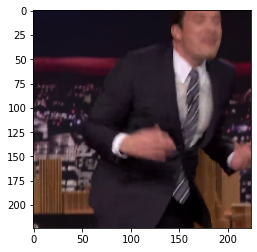

In [ ]:
plt.imshow(X[0][59])

In [ ]:
input_shape = (60,224,224,3)

In [ ]:
from keras.layers import Conv2D, BatchNormalization,MaxPool2D, GlobalMaxPool2D
from keras.models import Sequential

def build_convnet(shape=(224,224, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(32, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50

# def build_feature_extractor(input_shape=(224,224,3)):
#     feature_extractor = ResNet50(
#         weights="imagenet",
#         include_top=False,
#         pooling="avg"
#     )
#     inputs = keras.Input(input_shape)

#     outputs = feature_extractor(inputs)
#     return keras.Model(inputs, outputs, name="feature_extractor")


# feature_extractor = build_feature_extractor()

In [ ]:
# keras.utils.all_utils.plot_model(feature_extractor)

In [ ]:
import keras
from keras.layers import TimeDistributed,LSTM, Dense, Dropout

def action_model(shape=(60,224,224,3), nbout=2):
    # building the feature extractor
    convnet = build_convnet(input_shape[1:])
    # convnet = feature_extractor.predict(input_shape[1:])
    
    # then create our final model
    model = Sequential() 
    model.add(TimeDistributed(convnet, input_shape=shape))
    model.add(LSTM(32))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

In [ ]:
model = action_model(nbout=2)
model.compile('adam','binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_datagen,epochs=10,use_multiprocessing=True,validation_data=valid_datagen)

Epoch 1/10
592/592 [==============================] - 3960s 7s/step - loss: 0.7173 - accuracy: 0.4561 - val_loss: 0.7092 - val_accuracy: 0.0000e+00
Epoch 2/10
592/592 [==============================] - 3638s 6s/step - loss: 0.7042 - accuracy: 0.5084 - val_loss: 0.6941 - val_accuracy: 1.0000
Epoch 3/10
592/592 [==============================] - 3471s 6s/step - loss: 0.6944 - accuracy: 0.5524 - val_loss: 0.7015 - val_accuracy: 0.5556
Epoch 4/10
265/592 [============>.................] - ETA: 31:35 - loss: 0.6980 - accuracy: 0.5208

Process Keras_worker_ForkPoolWorker-13:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py", line 565, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/content/drive/MyDrive/Mini_Project_II/notebooks/helpers/preprocess.py", line 140, in __getitem__
    X,y = self._preprocess_data(list_samples_temp)
  File "/content/drive/MyDrive/Mini_Project_II/notebooks/helpers/preprocess.py", line 241, in _preprocess_data
    X.append(self._load_video(filepath))
  File "/content/drive/MyDrive/Mini_Project_II/notebooks/helpers/preprocess.py", line 200, in _load_video
    ret, frame = cap.read()
KeyboardInterrupt


In [ ]:
# for model
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('Image_Processing_Outputs\model_accuracy.pdf')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
# plt.savefig('Image_Processing_Outputs\model_loss.pdf')

## Image Simple CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Removing Missing Data from csv
tt0493405.00 not found. Removing entry from data
tt0493405.01 not found. Removing entry from data
tt0493405.02 not found. Removing entry from data
kCppUtS9vLk.00 not found. Removing entry from data
kCppUtS9vLk.01 not found. Removing entry from data
EbcfiIeH63M.00 not found. Removing entry from data
EbcfiIeH63M.01 not found. Removing entry from data
EbcfiIeH63M.02 not found. Removing entry from data
pxxPznV38Hk.00 not found. Removing entry from data
pxxPznV38Hk.01 not found. Removing entry from data
pxxPznV38Hk.02 not found. Removing entry from data
1yhNm_8q07g.00 not found. Removing entry from data
1yhNm_8q07g.01 not found. Removing entry from data
1yhNm_8q07g.02 not found. Removing entry from data
Final dataset shape:  (984, 7)
Taking only 592 samples (296 true + 296 false)
Final Dataframe shape :  (592, 7)


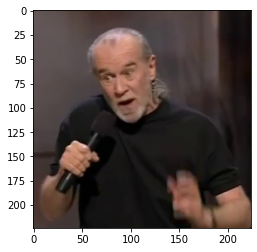

In [2]:
import sys
import os

# Project Directory
PROJECT_DIR = "/content/drive/MyDrive/Mini_Project_II"
sys.path.append(os.path.join(PROJECT_DIR,'notebooks'))
from helpers import preprocess


img_train_datagen = preprocess.get_img_datagen(small_sample=True)

# sample test
X_train, y_train = img_train_datagen.__getitem__(0)
X_train.shape,y_train.shape

import matplotlib.pyplot as plt
plt.imshow(X_train[100])


# Training Model
# history = model.fit(img_train_datagen,epochs=10,use_multiprocessing=True)

In [ ]:
import sys
import os

sys.path.append(os.path.join(PROJECT_DIR,'notebooks'))

In [ ]:
from helpers import preprocess

img_train_datagen = preprocess.get_img_datagen(small_sample=True)

Removing Missing Data from csv
tt0493405.00 not found. Removing entry from data
tt0493405.01 not found. Removing entry from data
tt0493405.02 not found. Removing entry from data
kCppUtS9vLk.00 not found. Removing entry from data
kCppUtS9vLk.01 not found. Removing entry from data
EbcfiIeH63M.00 not found. Removing entry from data
EbcfiIeH63M.01 not found. Removing entry from data
EbcfiIeH63M.02 not found. Removing entry from data
pxxPznV38Hk.00 not found. Removing entry from data
pxxPznV38Hk.01 not found. Removing entry from data
pxxPznV38Hk.02 not found. Removing entry from data
1yhNm_8q07g.00 not found. Removing entry from data
1yhNm_8q07g.01 not found. Removing entry from data
1yhNm_8q07g.02 not found. Removing entry from data
Final dataset shape:  (984, 7)
Taking only 592 samples (296 true + 296 false)
Final Dataframe shape :  (592, 7)


In [ ]:
X_train, y_train = img_train_datagen.__getitem__(0)
X_train.shape,y_train.shape

((120, 224, 224, 3), (120, 1))

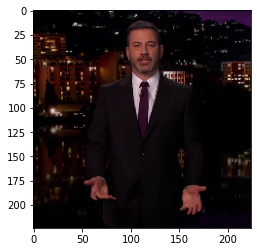

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[100])

In [3]:
from keras.layers import Conv2D, BatchNormalization,MaxPool2D, GlobalMaxPool2D
from keras.models import Sequential

def build_convnet(shape=(224,224, 3)):
    momentum = .9
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [4]:
input_shape = X_train.shape

In [5]:
from keras.layers import Dense, Dropout
def action_model(shape=(224,224,3), nbout=2):
    # building the feature extractor
    convnet = build_convnet(input_shape[1:])
    
    # then create our final model
    model = Sequential()
    model.add(convnet)
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [6]:
model = action_model(nbout=2)
model.compile('adam','binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(img_train_datagen,epochs=5,use_multiprocessing=True)

Epoch 1/5
296/296 [==============================] - 3695s 12s/step - loss: 0.8099 - accuracy: 0.4985
Epoch 2/5
Epoch 2/5
296/296 [==============================] - 3297s 11s/step - loss: 0.6964 - accuracy: 0.5093
Epoch 3/5
Epoch 3/5
206/296 [===================>..........] - ETA: 16:58 - loss: 0.6931 - accuracy: 0.4782